# Task 2 – Quantitative Analysis with TA-Lib & PyNance 📈

> Nova Financial Solutions &nbsp;•&nbsp; Week-1 Challenge

**Goals**

1. Load seven historical-price CSVs (`data/yfinance_data/*.csv`).  
2. Compute classic technical indicators with **TA-Lib**.  
3. Derive risk/return metrics with **PyNance**.  
4. Visualise trends & indicators.  
5. Save enriched datasets to `data/derived/`.

---


In [5]:
import pandas_ta as ta

In [9]:
# ⬛ Setup --------------------------------------------------------------------
#!pip install --quiet pandas numpy matplotlib seaborn tqdm pynance pandas_ta

import os, glob, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import pandas_ta as ta
import pynance as pn
from tqdm.notebook import tqdm

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")
%matplotlib inline


In [10]:
# ⬛ Helper functions ---------------------------------------------------------
def read_price_csv(path: str) -> pd.DataFrame:
    """Read one yfinance CSV and return cleaned DataFrame indexed on Date."""
    df = pd.read_csv(path)
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()
    num_cols = ["open", "high", "low", "close", "adj_close", "volume"]
    df[num_cols] = df[num_cols].astype(float)
    return df

def add_ta_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Append SMA-20/50, EMA-20, RSI-14, MACD to DataFrame using pandas_ta.
    """
    df = df.copy()

    # Moving averages
    df.ta.sma(length=20,  close='adj_close', append=True)
    df.ta.sma(length=50,  close='adj_close', append=True)
    df.ta.ema(length=20,  close='adj_close', append=True)

    # RSI
    df.ta.rsi(length=14,  close='adj_close', append=True)

    # MACD (creates MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9)
    df.ta.macd(close='adj_close', append=True)

    # Rename for clarity
    rename_map = {
        "SMA_20": "sma_20",
        "SMA_50": "sma_50",
        "EMA_20": "ema_20",
        "RSI_14": "rsi_14",
        "MACD_12_26_9":  "macd",
        "MACDh_12_26_9": "macd_hist",
        "MACDs_12_26_9": "macd_sig",
    }
    df = df.rename(columns=rename_map)

    return df


In [11]:
# ⬛ 1 / Load & enrich all tickers -------------------------------------------
DATA_DIR = "data/yfinance_data"
files    = glob.glob(os.path.join(DATA_DIR, "*_historical_data.csv"))

all_prices = {}
for fp in tqdm(files, desc="Reading CSVs"):
    tkr = os.path.basename(fp).split("_")[0].upper()
    df  = read_price_csv(fp)
    all_prices[tkr] = add_ta_indicators(df)
print("Loaded tickers:", list(all_prices))


Reading CSVs:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded tickers: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']


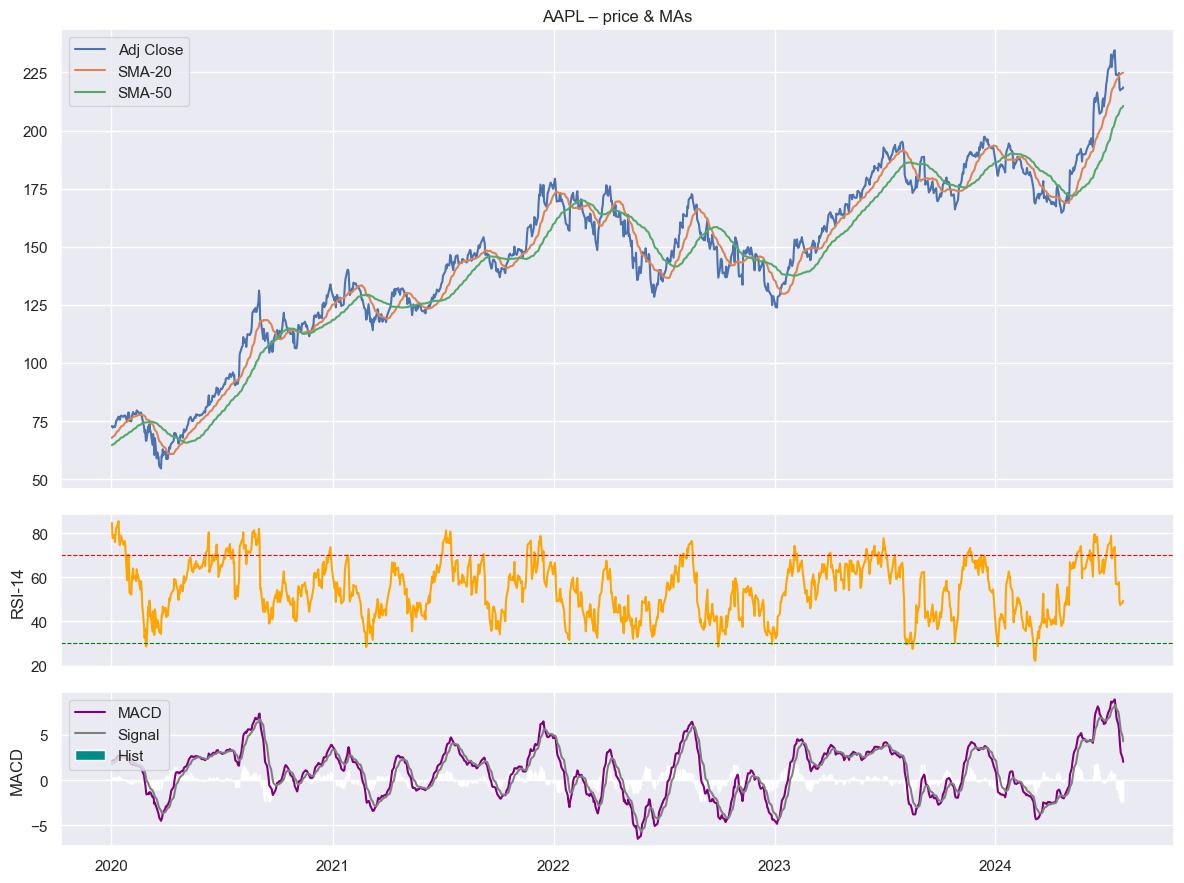

In [12]:
# ⬛ 2 / Plot helper ----------------------------------------------------------
def plot_price_indicators(df: pd.DataFrame, ticker: str,
                          start="2019-01-01", end=None):

    d = df.loc[start:end]

    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, figsize=(12, 9), sharex=True,
        gridspec_kw={"height_ratios": [3, 1, 1]}
    )

    ax1.plot(d.index, d["adj_close"], label="Adj Close")
    ax1.plot(d.index, d["sma_20"],   label="SMA-20")
    ax1.plot(d.index, d["sma_50"],   label="SMA-50")
    ax1.set_title(f"{ticker} ‒ price & MAs")
    ax1.legend()

    ax2.plot(d.index, d["rsi_14"], color="orange")
    ax2.axhline(70, color="red",  linestyle="--", lw=0.8)
    ax2.axhline(30, color="green",linestyle="--", lw=0.8)
    ax2.set_ylabel("RSI-14")

    ax3.plot(d.index, d["macd"],     label="MACD",   color="purple")
    ax3.plot(d.index, d["macd_sig"], label="Signal", color="grey")
    ax3.bar (d.index, d["macd_hist"],label="Hist",   color="darkcyan")
    ax3.set_ylabel("MACD")
    ax3.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

# Demo ― AAPL 2020-present
plot_price_indicators(all_prices["AAPL"], "AAPL", start="2020-01-01")


In [15]:
# ⬛ 3 / Risk-return metrics via PyNance -------------------------------------
def metrics(df: pd.DataFrame, rf=0.01):
    price   = df["adj_close"].dropna()
    returns = price.pct_change().dropna()
    return {
        "CAGR":        cagr(price),
        "Volatility":  annual_volatility(returns),
        "Sharpe":      sharpe_ratio(returns, rf),
        "MaxDD":       max_drawdown(price),
    }


summary = (pd.DataFrame({t: metrics(df) for t, df in all_prices.items()})
           .T
           .sort_values("Sharpe", ascending=False)
          )
summary.style.format({"CAGR":"{:.2%}", "Volatility":"{:.2%}",
                      "Sharpe":"{:.2f}", "MaxDD":"{:.2%}"})


,CAGR,Volatility,Sharpe,MaxDD
TSLA,42.01%,56.94%,0.88,-73.63%
MSFT,25.96%,33.50%,0.83,-69.39%
GOOG,23.64%,30.67%,0.81,-65.29%
NVDA,36.40%,60.11%,0.80,-89.72%
META,27.47%,38.54%,0.80,-76.74%
AMZN,31.86%,56.24%,0.75,-94.40%
AAPL,19.30%,44.28%,0.60,-81.80%


In [16]:
# ⬛ 4 / Persist enriched data ----------------------------------------------
os.makedirs("data/derived", exist_ok=True)
for tkr, df in all_prices.items():
    df.to_csv(f"data/derived/{tkr}_enriched.csv")
print("Saved to data/derived/ ✅")


Saved to data/derived/ ✅
